In [1]:
%reload_ext autoreload
%autoreload 2

import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn.cluster import KMeans
import statsmodels.api as sm
from lib import utils

folder_path = "jatos_results_20240125"
metadata_path = "jatos_results_20240125/metadata.json"

mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = 16

In [2]:
%run -i lib\load_data

Save meta data as meta_data.csv
Main data loaded successfully.
Number of participants who fail consistency check: 40
Worker IDs to be excluded: ['434924', '434925', '434933', '434938', '434939', '434948', '434950', '434951', '434956', '434965', '434970', '434973', '434975', '434987', '434991', '434994', '435006', '435007', '435012', '435014', '435023', '435025', '435034', '435037', '435044', '435050', '435051', '435061', '435071', '435078', '435082', '435085', '435088', '435091', '435094', '435102', '435109', '435112', '435125', '435126']
Consistency check finished.
Number of subjects in each cluster:
K-means [105  52]
GMM [95 62]


In [3]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)

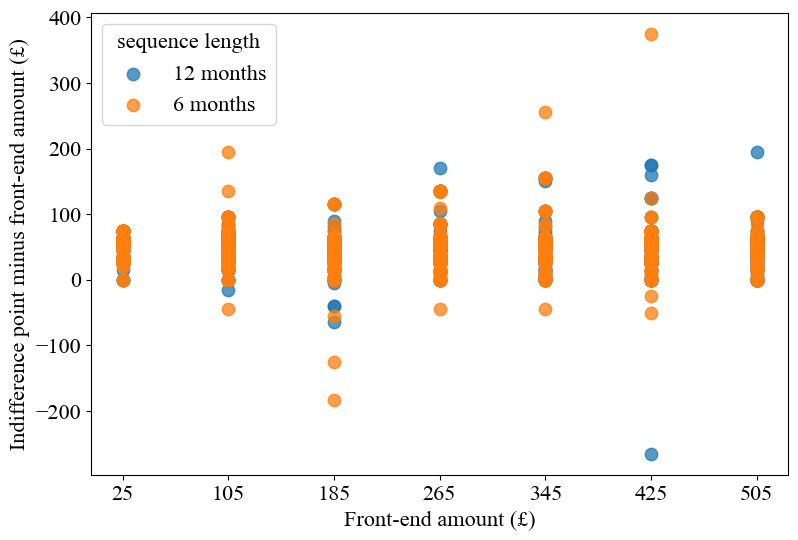

In [4]:
# Plot: check outliers
df_plot = df.groupby(['seq_length','front_amount'])['indiff_point'].mean().to_frame().reset_index()
seq_length_list = df_plot['seq_length'].unique()
front_amount_list = df_plot['front_amount'].unique()

plt.figure(figsize=(9, 6))
for t in seq_length_list:
    tab_plot = df[df['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['value_surplus'],label=t,alpha=0.75,s=80)

# Add title and labels
plt.xlabel('Front-end amount (£)')
plt.ylabel('Indifference point minus front-end amount (£)')
plt.xticks(front_amount_list)
plt.legend(loc=2,title='sequence length')
plt.show()

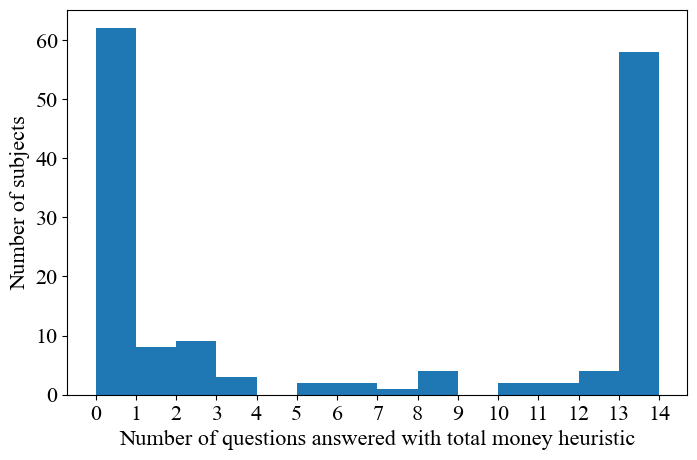

In [5]:
df['total_money_heuristic'] = df['value_surplus'] == 60
plt.figure(figsize=(8,5))
plt.hist(df.groupby('worker_id')['total_money_heuristic'].sum(),bins=14)
plt.xticks(np.arange(15))
plt.ylabel('Number of subjects')
plt.xlabel('Number of questions answered with total money heuristic')
plt.show()

Text(0.5, 0, 'front-end amount (£)')

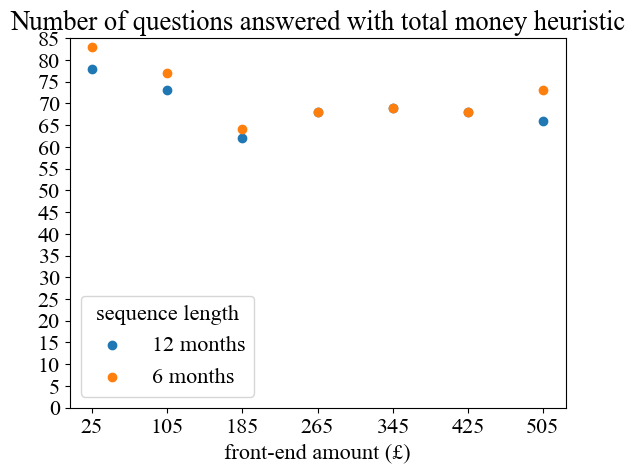

In [6]:
df_plot = df.groupby(['seq_length','front_amount'])['total_money_heuristic'].sum().to_frame().reset_index()
front_amount_list = df_plot['front_amount'].unique()

for t in seq_length_list:
    tab_plot = df_plot[df_plot['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['total_money_heuristic'],label=t)

plt.title('Number of questions answered with total money heuristic')
plt.legend(loc='best',title='sequence length')
plt.xticks(front_amount_list)
plt.yticks(np.arange(0,90,step=5))
plt.xlabel('front-end amount (£)')

Text(0.5, 0, 'front-end amount (£)')

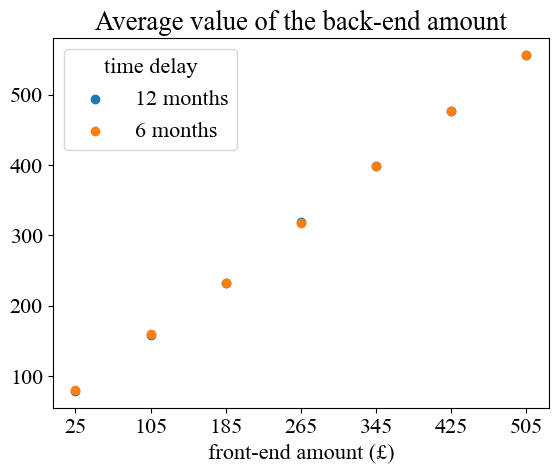

In [7]:
df_plot = df.groupby(['seq_length','front_amount'])['indiff_point'].mean().to_frame().reset_index()
front_amount_list = df_plot['front_amount'].unique()

for t in seq_length_list:
    tab_plot = df_plot[df_plot['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['indiff_point'],label=t)

plt.title('Average value of the back-end amount')
plt.legend(loc='best',title='time delay')
plt.xticks(front_amount_list)
plt.xlabel('front-end amount (£)')

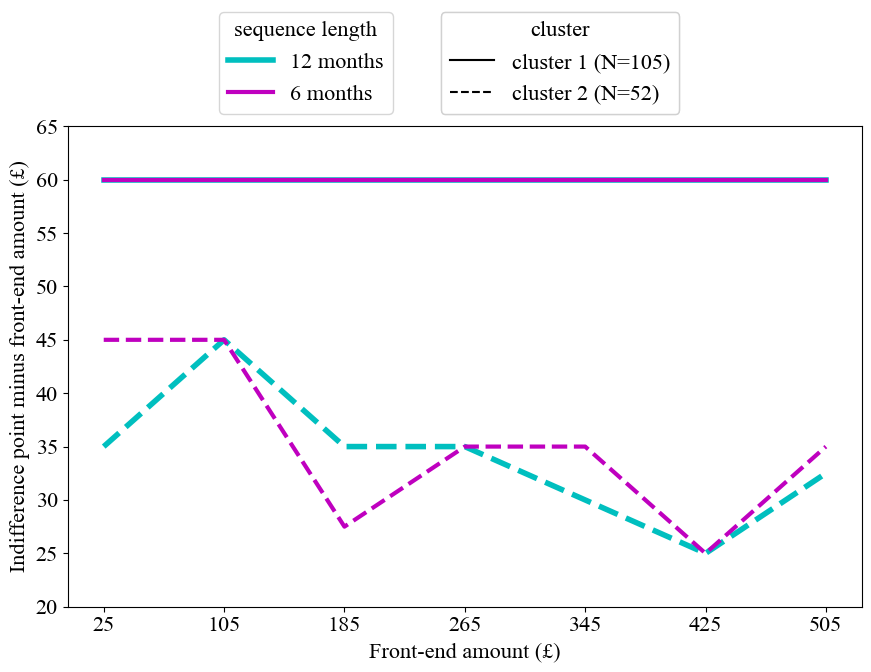

In [8]:
utils.median_plot(df,label_name='label_kmeans')

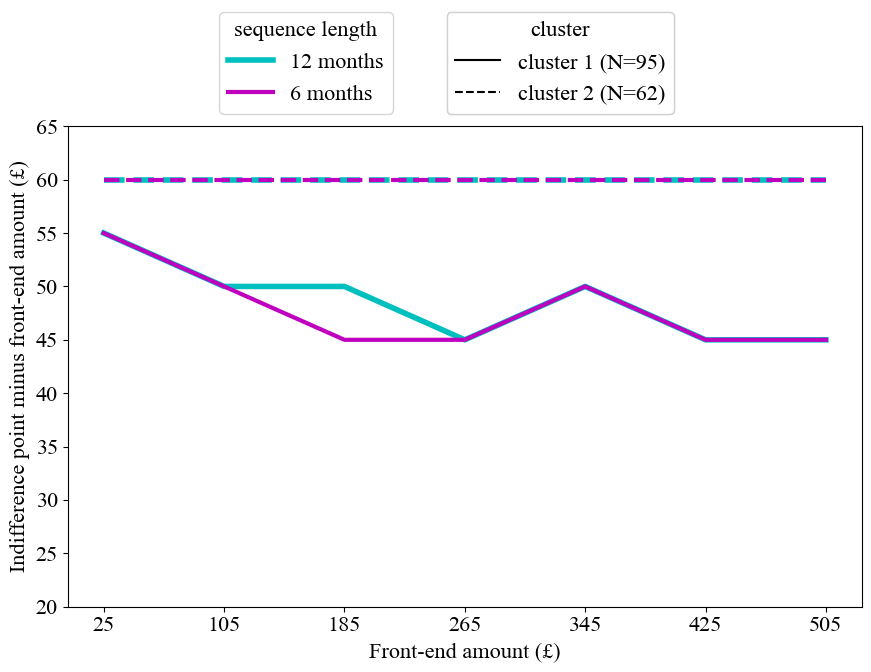

In [9]:
utils.median_plot(df,label_name='label_gmm')

In [10]:
print('Mean response time, split by whether using total money heuristic')
print(df.groupby('total_money_heuristic')['response_time_enter'].mean())
print(stats.ttest_ind(df['response_time_enter'][df['total_money_heuristic'] == 0],
                df['response_time_enter'][df['total_money_heuristic'] == 1]))
print('')
print('Ratio of answers using total money heuristic, split by k-means clustered label')
print(df.groupby('label_kmeans')['total_money_heuristic'].mean())
print(stats.ttest_ind(df['total_money_heuristic'][df['label_kmeans'] == 0],
                df['total_money_heuristic'][df['label_kmeans'] == 1]))
print('')
print('Ratio of answers using total money heuristic, split by GMM clustered label')
print(df.groupby('label_gmm')['total_money_heuristic'].mean())
print(stats.ttest_ind(df['total_money_heuristic'][df['label_gmm'] == 0],
                df['total_money_heuristic'][df['label_gmm'] == 1]))
print('')
print('mean response time, split by GMM clustered label')
print(df.groupby('label_gmm')['response_time_enter'].mean())
print(stats.ttest_ind(df['response_time_enter'][df['label_gmm'] == 0],
                df['response_time_enter'][df['label_gmm'] == 1]))

Mean response time, split by whether using total money heuristic
total_money_heuristic
False    10899.804455
True      9282.460446
Name: response_time_enter, dtype: float64
TtestResult(statistic=4.169277943917821, pvalue=3.174277835455027e-05, df=2196.0)

Ratio of answers using total money heuristic, split by k-means clustered label
label_kmeans
0    0.626531
1    0.089286
Name: total_money_heuristic, dtype: float64
TtestResult(statistic=27.66682532129962, pvalue=8.399471838102829e-145, df=2196.0)

Ratio of answers using total money heuristic, split by GMM clustered label
label_gmm
0    0.196992
1    0.834101
Name: total_money_heuristic, dtype: float64
TtestResult(statistic=-37.637163703995554, pvalue=1.1639491910073853e-239, df=2196.0)

mean response time, split by GMM clustered label
label_gmm
0    10490.62782
1     9689.55530
Name: response_time_enter, dtype: float64
TtestResult(statistic=2.02357181648186, pvalue=0.04313512514948463, df=2196.0)


In [11]:
# Spearman rank-order correlation
# the entire sample
print(stats.spearmanr(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.spearmanr(df[df['label_gmm'] == 0]['value_surplus'],
                df[df['label_gmm'] == 0]['front_amount']))

# cluster 2
print(stats.spearmanr(df[df['label_gmm'] == 1]['value_surplus'],
                    df[df['label_gmm'] == 1]['front_amount']))

SignificanceResult(statistic=-0.043245998593847375, pvalue=0.04263276342226129)
SignificanceResult(statistic=-0.09914461370375677, pvalue=0.0002931867877560926)
SignificanceResult(statistic=0.017564898214393918, pvalue=0.6053039131541476)


In [12]:
df['front_amount_6m'] = df['front_amount'] * (df['seq_length'] == '6 months')
df['front_amount_12m'] = df['front_amount'] * (df['seq_length'] == '12 months')
df['front_amount_6m_0'] = df['front_amount_6m']  * (df['label_gmm'] == 0)
df['front_amount_6m_1'] = df['front_amount_6m']  * (df['label_gmm'] == 1)
df['front_amount_12m_0'] = df['front_amount_12m']  * (df['label_gmm'] == 0)
df['front_amount_12m_1'] = df['front_amount_12m']  * (df['label_gmm'] == 1)


df_dummy = pd.concat([df,pd.get_dummies(df['worker_id'], prefix='worker_id')],axis=1)
df_filtered = utils.rule_out_outlier(df_dummy,col_name='value_surplus')

reg_cols_baseline = ['front_amount_6m','front_amount_12m','choice_peli']
reg_cols_label = ['front_amount_6m_0','front_amount_12m_0','front_amount_6m_1','front_amount_12m_1','choice_peli']
reg_cols_dummy = reg_cols_baseline + [col for col in df_dummy.columns if col.startswith('worker_id_')]
reg_cols_dummy_2 = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]

Number of outliers (lower and upper): [4, 8]


In [13]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_baseline]).astype(float)
model_rlm_pool_1 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale(),cov='H2')
model_rlm_pool_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2198
Model:                                                                            RLM   Df Residuals:                     2194
Method:                                                                          IRLS   Df Model:                            3
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x0000025E288BCA10>                                         
Cov Type:                                                                          H2                                         
Date:                                                                Mon, 05 Feb 2024                                         
Time:                                                                        17:40:43                                         
No. Iterations:                                                                    12                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               55.0002      0.987     55.735      0.000      53.066      56.934
front_amount_6m     -0.0048      0.002     -1.938      0.053      -0.010    5.55e-05
front_amount_12m    -0.0060      0.003     -2.396      0.017      -0.011      -0.001
choice_peli         -0.8484      0.891     -0.952      0.341      -2.595       0.898
====================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [14]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_label]).astype(float)
model_rlm_pool_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale(),cov='H2')
model_rlm_pool_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2198
Model:                                                                            RLM   Df Residuals:                     2192
Method:                                                                          IRLS   Df Model:                            5
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x0000025E288B2A50>                                         
Cov Type:                                                                          H2                                         
Date:                                                                Mon, 05 Feb 2024                                         
Time:                                                                        17:40:44                                         
No. Iterations:                                                                    13                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 53.9216      0.891     60.530      0.000      52.176      55.668
front_amount_6m_0     -0.0253      0.003     -9.822      0.000      -0.030      -0.020
front_amount_12m_0    -0.0281      0.003    -10.708      0.000      -0.033      -0.023
front_amount_6m_1      0.0211      0.003      7.493      0.000       0.016       0.027
front_amount_12m_1     0.0212      0.003      7.502      0.000       0.016       0.027
choice_peli            0.8913      0.805      1.107      0.269      -0.687       2.470
======================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [15]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)
model_rlm_fe = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale(),cov='H2')

pd.concat([model_rlm_fe.params[reg_cols_baseline].rename('coef'),
           model_rlm_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_rlm_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.004768,1.299708e-06,-0.006699,-0.002837
front_amount_12m,-0.006412,9.138827e-11,-0.008351,-0.004473
choice_peli,2.181327,NaN,NaN,NaN


In [16]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy_2]).astype(float)
model_rlm_fe_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale(),cov='H2')

pd.concat([model_rlm_fe_2.params[reg_cols_label].rename('coef'),
           model_rlm_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_rlm_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,-0.009692,4.553793e-14,-1.221048e-02,-7.174307e-03
front_amount_12m_0,-0.012670,8.498047e-23,-1.519710e-02,-1.014367e-02
front_amount_6m_1,0.001801,2.261677e-01,-1.115626e-03,4.717806e-03
front_amount_12m_1,0.001906,1.983054e-01,-9.978688e-04,4.809363e-03
choice_peli,2.583942,9.999998e-01,-2.297141e+07,2.297141e+07


NormaltestResult(statistic=1410.0188434066422, pvalue=6.581099613250527e-307)


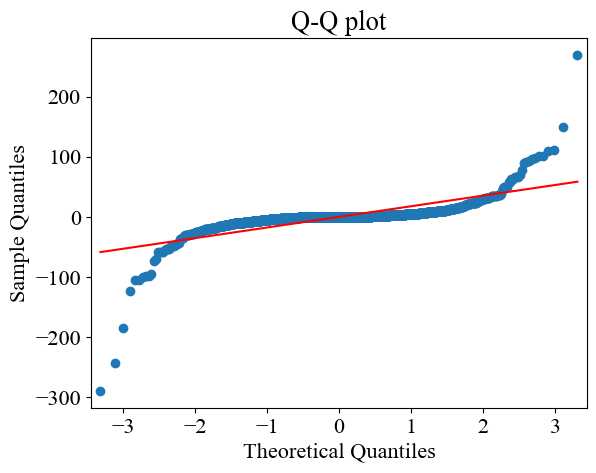

In [17]:
pplot = sm.ProbPlot(model_rlm_fe_2.resid)
fig = pplot.qqplot(line='s')
plt.title('Q-Q plot')
print(stats.normaltest(model_rlm_fe_2.resid))

In [18]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_1,param_names=reg_cols_baseline,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_baseline.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:28<00:00, 34.57it/s]


In [19]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_2,param_names=reg_cols_label,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_label.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:34<00:00, 28.77it/s]


In [20]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe,param_names=reg_cols_baseline,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_baseline.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [31:52<00:00,  1.91s/it]


In [21]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe_2,param_names=reg_cols_label,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_label.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [30:16<00:00,  1.82s/it] 


In [22]:
# save regression results
model_results = {
                 'rlm_pool_baseline':utils.get_reg_result(model_rlm_pool_1,reg_cols_baseline),
                 'rlm_pool_label':utils.get_reg_result(model_rlm_pool_2,reg_cols_label),
                 'rlm_fe_baseline':utils.get_reg_result(model_rlm_fe,reg_cols_baseline),
                 'rlm_fe_label':utils.get_reg_result(model_rlm_fe_2,reg_cols_label)
                 }

with open('model_reg_result_gm.json', "w") as f:
    json.dump(model_results, f)